# SBU CSE 352 - HW 1 -  Intelligent Agents: Reflex-Based Agents for the Vacuum-cleaner World

---

Name: Cody Lam

I understand that my submission needs to be my own work: yes

## Instructions

Total Points: 100

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy, scipy, and built-in packages like random). Submit the completely rendered notebook as a HTML file.

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex-based agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square in the room has been cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [2]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [3]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'west'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a performance measure which is here the number of cleaned squares (since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room as required in the PEAS description above). The energy budget of the agent is specified as `max_steps`.

In [4]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0

    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action)

        if (action == "suck"):
            num_cleaned = num_cleaned + 1

    return num_cleaned



Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [5]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: south
step 1 - action: south
step 2 - action: north
step 3 - action: east
step 4 - action: south
step 5 - action: north
step 6 - action: suck
step 7 - action: north
step 8 - action: north
step 9 - action: north
step 10 - action: west
step 11 - action: west
step 12 - action: suck
step 13 - action: suck
step 14 - action: south
step 15 - action: south
step 16 - action: suck
step 17 - action: east
step 18 - action: north
step 19 - action: north


4

# Tasks

## General [10 Points]

1. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design, for example. If it makes your code more simple objects are okay, but try to keep the code as simple as possible.
2. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.


## Task 1: Implement a simulation environment [20 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty. ([Help with random numbers and arrays in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/random_numbers_and_arrays.ipynb))
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment should be a function like the `simple_environment()` and needs to work with the simple randomized agent program from above. **Use the same environment for all your agent implementations in the tasks below.**

*Note on debugging:* Debugging is difficult. Make sure your environment prints enough information when you use `verbose = True`. Also, implementing a function that the environment can use to displays the room with dirt and the current position of the robot at every step is very useful.  

In [110]:
# Your code and description goes here
import random
import numpy as np

# Initialize an environment storing the state of each square either making it dirty or clean
def create_environment(n=5, p=0.2):
  environment = np.random.choice([0, 1], size=(n,n), p = [1 - p, p])
  return environment

# Environment can use to display the dirty and clean squares
def display_environment(environment, agent_position):
  display = environment.copy().astype(str)
  display[display == '1'] = 'D'
  display[display == '0'] = '.'
  x, y = agent_position
  display[x,y] = "V"
  for row in display:
    print(' '.join(row))
  print('\n')

# Simulates an environment using the simple agent (n: size of the matrix)
def simulation_environment(agent, max_steps=100, n=5, p=0.2, verbose=True, model_based=False):
  environment = create_environment(n, p)
  agent_position = [random.randint(0 , n-1), random.randint(0, n-1)]
  steps = 0 # Keeps track of the amount of actions the vaccum takes
  state = None  # Initial state for model-based agent

  while np.any(environment == 1) and steps < max_steps:
    x, y = agent_position
    dirty = environment[x, y] == 1
    walls = {"north": x == 0, "south": x == n-1, "west": y == 0, "east": y == n-1}

    if model_based:
      action, state = agent(walls, dirty, state)
    else:
      action = agent(walls, dirty) # Uses the simple randomized agent

    if verbose:
      print(f"Step {steps}: Action = {action}")
      display_environment(environment, agent_position)

    if action == "suck" and dirty: # If the action is suck on a dirty square then you clean it
      environment[x, y] = 0
    elif action == "north" and not walls["north"]:
      agent_position[0] -= 1
    elif action == "south" and not walls["south"]:
        agent_position[0] += 1
    elif action == "west" and not walls["west"]:
        agent_position[1] -= 1
    elif action == "east" and not walls["east"]:
        agent_position[1] += 1

    steps += 1
  return steps

steps = simulation_environment(simple_randomized_agent, verbose=True)
print(f"Total Steps: {steps}")

Step 0: Action = south
. . . D .
. D . . .
D . . . .
. . . . D
. . . . V


Step 1: Action = suck
. . . D .
. D . . .
D . . . .
. . . . D
. . . . V


Step 2: Action = suck
. . . D .
. D . . .
D . . . .
. . . . D
. . . . V


Step 3: Action = suck
. . . D .
. D . . .
D . . . .
. . . . D
. . . . V


Step 4: Action = suck
. . . D .
. D . . .
D . . . .
. . . . D
. . . . V


Step 5: Action = suck
. . . D .
. D . . .
D . . . .
. . . . D
. . . . V


Step 6: Action = suck
. . . D .
. D . . .
D . . . .
. . . . D
. . . . V


Step 7: Action = suck
. . . D .
. D . . .
D . . . .
. . . . D
. . . . V


Step 8: Action = east
. . . D .
. D . . .
D . . . .
. . . . D
. . . . V


Step 9: Action = south
. . . D .
. D . . .
D . . . .
. . . . D
. . . . V


Step 10: Action = suck
. . . D .
. D . . .
D . . . .
. . . . D
. . . . V


Step 11: Action = south
. . . D .
. D . . .
D . . . .
. . . . D
. . . . V


Step 12: Action = suck
. . . D .
. D . . .
D . . . .
. . . . D
. . . . V


Step 13: Action = north
. . . D 

## Task 2:  Implement a simple reflex agent [10 Points]

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function.

In [133]:
# Your code and description goes here
def simple_reflex_agent(bumpers, dirty):
  if dirty:
    return "suck"
  else:
    possible_moves = [action for action in ["north", "east", "west", "south"] if not bumpers[action]]
    if possible_moves:
        return random.choice(possible_moves)
    else:
        return "suck"

steps = simulation_environment(simple_reflex_agent, verbose=True)
print(f"Total Steps: {steps}")

Step 0: Action = south
. V . . .
. D . . .
D . . . .
. . . . D
. . . . .


Step 1: Action = suck
. . . . .
. V . . .
D . . . .
. . . . D
. . . . .


Step 2: Action = east
. . . . .
. V . . .
D . . . .
. . . . D
. . . . .


Step 3: Action = west
. . . . .
. . V . .
D . . . .
. . . . D
. . . . .


Step 4: Action = north
. . . . .
. V . . .
D . . . .
. . . . D
. . . . .


Step 5: Action = east
. V . . .
. . . . .
D . . . .
. . . . D
. . . . .


Step 6: Action = west
. . V . .
. . . . .
D . . . .
. . . . D
. . . . .


Step 7: Action = east
. V . . .
. . . . .
D . . . .
. . . . D
. . . . .


Step 8: Action = south
. . V . .
. . . . .
D . . . .
. . . . D
. . . . .


Step 9: Action = east
. . . . .
. . V . .
D . . . .
. . . . D
. . . . .


Step 10: Action = east
. . . . .
. . . V .
D . . . .
. . . . D
. . . . .


Step 11: Action = west
. . . . .
. . . . V
D . . . .
. . . . D
. . . . .


Step 12: Action = north
. . . . .
. . . V .
D . . . .
. . . . D
. . . . .


Step 13: Action = west
. . . V 

## Task 3: Implement a model-based reflex agent [20 Points]

Model-based agents use a state to keep track of what they have done and perceived so far. Your agent needs to find out where it is located and then keep track of its current location. You also need a set of rules based on the state and the percepts to make sure that the agent will clean the whole room. For example, the agent can move to a corner to determine its location and then it can navigate through the whole room and clean dirty squares.

Describe how you define the __agent state__ and how your agent works before implementing it. ([Help with implementing state information on Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb))

In [ ]:
# Your short description of the state and your implementation goes here
""" The agent's state keeps track of the position that the vaccuum is currently in and all the positions that it already visited and navigates the grid to ensure all dirty squares are cleans """

In [80]:
def model_based_reflex_agent(bumpers, dirty, state):
  # Initialize the state
  if state is None:
    state = {"position": [0,0], "visited": set(), "direction": "east", "backtrack_stack":[]}

  x, y = state["position"]
  state["visited"].add((x, y))

  if dirty:
      return "suck", state

  directions = ["east", "south", "west", "north"]
  dx_dy = {"north": (-1, 0), "south": (1, 0), "west": (0, -1), "east": (0, 1)}

  for direction in directions:
      if not bumpers[direction]:
          nx, ny = x + dx_dy[direction][0], y + dx_dy[direction][1]
          if (nx, ny) not in state["visited"]:
              state["backtrack_stack"].append((x, y))
              state["position"] = [nx, ny]
              return direction, state

  if state["backtrack_stack"]:
        backtrack_position = state["backtrack_stack"].pop()
        bx, by = backtrack_position
        for direction in directions:
            if not bumpers[direction]:
                nx, ny = x + dx_dy[direction][0], y + dx_dy[direction][1]
                if (nx, ny) == (bx, by):
                    state["position"] = [nx, ny]
                    return direction, state

  return "suck", state # default if there is no other option

steps = simulation_environment(model_based_reflex_agent, n = 5, verbose=True, model_based=True)
print(f"Total Steps: {steps}")

Step 0: Action = south
. . . D V
. D . D .
. . . . .
. . . . .
. D D D D


Step 1: Action = south
. . . D .
. D . D V
. . . . .
. . . . .
. D D D D


Step 2: Action = south
. . . D .
. D . D .
. . . . V
. . . . .
. D D D D


Step 3: Action = south
. . . D .
. D . D .
. . . . .
. . . . V
. D D D D


Step 4: Action = suck
. . . D .
. D . D .
. . . . .
. . . . .
. D D D V


Step 5: Action = west
. . . D .
. D . D .
. . . . .
. . . . .
. D D D V


Step 6: Action = suck
. . . D .
. D . D .
. . . . .
. . . . .
. D D V .


Step 7: Action = west
. . . D .
. D . D .
. . . . .
. . . . .
. D D V .


Step 8: Action = suck
. . . D .
. D . D .
. . . . .
. . . . .
. D V . .


Step 9: Action = west
. . . D .
. D . D .
. . . . .
. . . . .
. D V . .


Step 10: Action = suck
. . . D .
. D . D .
. . . . .
. . . . .
. V . . .


Step 11: Action = west
. . . D .
. D . D .
. . . . .
. . . . .
. V . . .


Step 12: Action = north
. . . D .
. D . D .
. . . . .
. . . . .
V . . . .


Step 13: Action = east
. . . D

## Task 4: Simulation study [30 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each with 100000 max steps. Present the results using tables and graphs. Discuss the differences between the agents.
([Help with charts and tables in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/charts_and_tables.ipynb))

In [117]:
# Your code goes here
import matplotlib.pyplot as plt
import pandas as pd

grid_sizes = [5, 10, 100] # 5x5, 10x10, 100x100
agents = { "Simple Randomized Agent" : simple_randomized_agent,
          "Simple Reflex Agent": simple_reflex_agent,
           "Model-Based Reflex Agent" :model_based_reflex_agent }

# Run a simulation of 100 random runs, 100000 steps for a given agent
def run_simulations(agent, grid_sizes, runs=100, max_steps=100000, model_based=False):
  results = {}
  for size in grid_sizes:
    for _ in range(runs):
      performance = simulation_environment(agent, n=size, max_steps=max_steps, verbose=False, model_based=model_based)
    results[size] = performance
  return results

all_results = {}

for agent_name, agent_func in agents.items():
  model_based = ("Model-Based" in agent_name)
  results = run_simulations(agent_func, grid_sizes, model_based=model_based)
  all_results[agent_name] = results

# for agent_name, results in all_results.items():
#     df = pd.DataFrame({size: results[size] for size in grid_sizes})
#     print(f"Performance for {agent_name}:")
#     print(df.describe())
#     print("\n")

Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     | | | |
| 10x10   | | | |
| 100x100 | | | |

Add charts to compare the performance of the different agents.

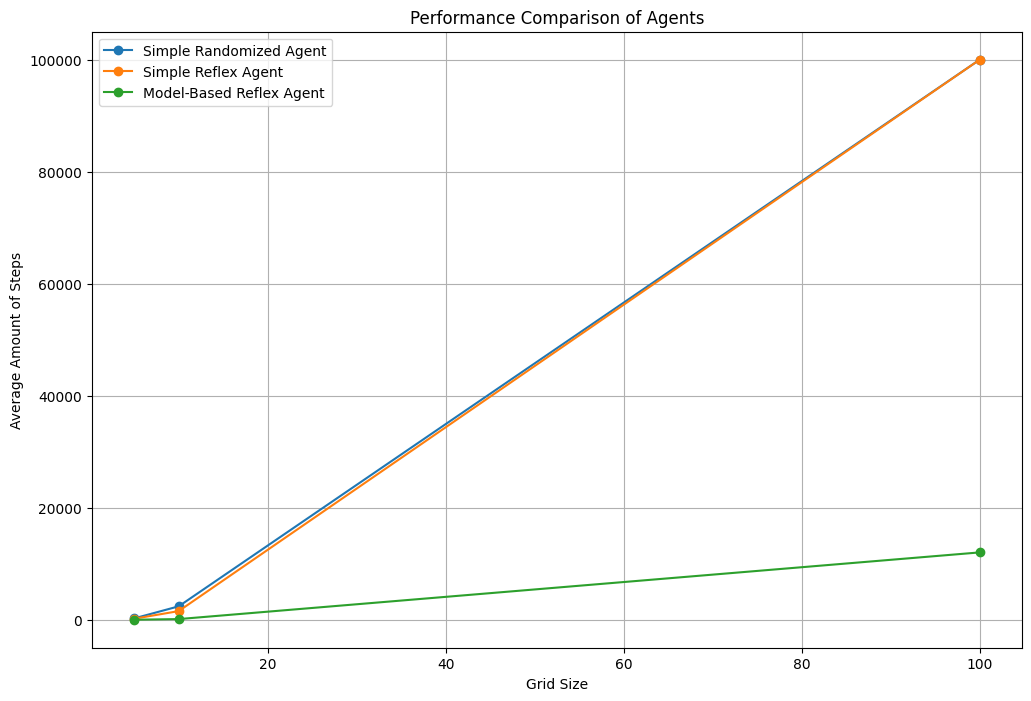

In [118]:
# Your graphs and discussion of the results goes here
plt.figure(figsize=(12, 8))

for agent_name, results in all_results.items():
    means = [np.mean(results[size]) for size in grid_sizes]
    plt.plot(grid_sizes, means, marker='o', label=agent_name)

plt.xlabel('Grid Size')
plt.ylabel('Average Amount of Steps')
plt.title('Performance Comparison of Agents')
plt.legend()
plt.grid(True)
plt.show()

## Task 5: Robustness of the agent implementations [10 Points]

Describe how **your agent implementations** will perform

* if it is put into a rectangular room with unknown size,
* if the cleaning area can have an irregular shape (e.g., a hallway connecting two rooms), or
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

In [ ]:
# Answer goes here
"""
1. If it was placed in a rectangular room with unkown size:
  - Using a Simple Randomized Agent it will still function but it is really inefficient because it performs actions randomly and could potentially miss cleaning an area repeatedly
  - Using a Reflex Agent will perform slightly better because it will avoid any walls and it will react when it reaches a dirty area and it will clean it. However, it could move to the same place it
    already went to, so it lacks the memory to perform systematic cleaning
  - Using a Model-Based Agent would perform the best because it keeps track of the visited squares

2. If the cleaning area was a irregular shape:
  - Using a Simple Randomized Agent would be inefficient because it is exploring the room randomly, so it will take a lot time to find the path with a narrow space
  - Using a Reflex Agent would perform a little better because of the bump sensors and it will handle narrow spaces better, but it could miss dirty areas even after it crosses the hallway
  - Using a Model-Based Agent

3. If the room contained obstacles
  - Using a Simple Randomized Agent would be inefficient since it would waste a lot of its actions by bumping into the obstacle repeatedly
  - Using a Reflex Agent would
"""



---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
